In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import logging
from pathlib import Path
import textwrap
import copy
from PIL import Image, ImageDraw, ImageFont
from waveshare_epd import epd2in7b
from waveshare_epd import epd5in83

In [6]:
import random

In [7]:
import constants


In [8]:
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

In [282]:
class xTextBlock:
    '''Class for creating a 1 bit image of word-wrapped text
    
    Args
    ----
        resolution (int, int): tuple of ints representing maximum resolution of image
        text (str): text to format into image
        font (str): path to ttf font
        size (int): size of font in points (pixles)
        max_lines (int): maximum number of wrapped rows of text; surplus is discarded
        maxchar (int): maximum number of characters per row
            this is automatically calculated if not specified based on font face, font size
            and letter frequency (see chardist below)
        hcenter (bool): horiziontally center-align the text block (default False) and align horizontally
                        within the absolute coordinates
        vcenter (bool): vertically center-align the text block within the absolute coordinates
        chardist (dict): character frequency distribution for a particular language
            provided distributions in constants.py: 
            USA_CHARDIST+, FRA_CHARDIST, DEU_CHARDIST, PRT_CHARDIST, ITA_CHARDIST, TUR_CHARDIST,
            SWE_CHARDIST, NED_CHARDIST, DAN_CHARDIST
                + only USA english includes upper and lower case characters
        coordinates (int, int): location on screen image should be positioned (not used locally)
    
    Attributes
    ----------
        resolution (int, int): max resolution of image in px
        font (ImageFont.trueType): font and size to use
        maxchar (int): maximum number of characters per row
        max_lines (int): maximum number of wrapped rows of text; surplus is discarded
        coordinates (int, int): position of text in final image (not used in this class)
        size (int, int): size of text image in px
        text (str): raw text
        formatted (str): wrapped text
        textimage (ImageDraw.Draw): 1 bit image containing formatted text text


    '''
    def __init__(self, resolution=(600, 448), text=' ', font=constants.FONT, size=24, max_lines=3,
                 maxchar=None, hcenter=False, vcenter=False, coordinates=(0, 0), chardist=None):
        self.resolution=resolution
        self.font = ImageFont.truetype(str(Path(font).absolute()), size)
        if chardist:
            self._chardist = chardist
        else:
            self._chardist = constants.USA_CHARDIST
        self.maxchar = maxchar
        self.hcenter = hcenter
        self.vcenter = vcenter
        self.dimensions = (0, 0)
        self.max_lines = max_lines
        self.coordinates = coordinates
        self.image = None
        self.text = text
    
        
    @property
    def resolution(self):
        '''maximum resolution in for image
        
        ::2-tuple of int'''
        return self._resolution
    
    @resolution.setter
    def resolution(self, resolution):
#         for r in resolution:
#             if not isinstance(r, int):
#                 raise TypeError(f'resolution must be type int: {r}')
#             if r < 0:
#                 raise ValueError(f'resolution must be positive: {r}')
        if self.coordcheck(resolution):
            self._resolution = resolution
        else:
            raise ValueError(f'bad resolution value: {resolution}')
    
    @property
    def coordinates(self):
        '''coordinates to place the formatted text within the final image (not used in this method)
        
        ::2 tuple of int'''
        return self._coordinates
    
    @coordinates.setter
    def coordinates(self, coordinates):
        if self.coordcheck(coordinates):
            self._coordinates = coordinates
        else:
            raise ValueError(f'bad coordinate values: {coordinates}')
    
    @property
    def maxchar(self):
        '''maximum number of characters per row
            if no value is set this is calculated based on font face, font size and letter frequency
            
        ::int'''
        return self._maxchar
    
    @maxchar.setter
    def maxchar(self, maxchar):
        if maxchar:
            self.__maxchar = maxchar
            return(maxchar)
        else:
            s = ''
            n = 1000 # sample string size for measuring
            # create a string of characters containing the letter distribution
            for char in self._chardist:
                s = s+(char*int(self._chardist[char]*n))
            sLenPX = self.font.getsize(s)[0] # string length in Pixles
            avgCharLen = sLenPX/len(s)
            maxchar = round(self.resolution[0]/avgCharLen)
            self._maxchar = maxchar
            logging.debug(f'maximum characters/line: {maxchar}')
    
    @property
    def text(self):
        '''raw text
        
        ::str'''
        return self._text
    
    @text.setter
    def text(self, text):
        if not text:
            self.text = None
        else:
            self._text = text
            self.formatted = self.formattext()
            self.image = self.textimage()
    
    @property
    def max_lines(self):
        '''maximum number of rows to use when wrapping text
        
        ::int'''
        return self._max_lines
    
    @max_lines.setter
    def max_lines(self, max_lines):
        if max_lines < 1:
            raise ValueError(f'max_lines must be greater than 0: {max_lines}')
        if not isinstance(max_lines, int):
            raise ValueError(f'max_lines must be type integer: {max_lines}')
        self._max_lines = max_lines
    
    def formattext(self, text=None, maxchar=None, max_lines=None):
        '''format text using word-wrap strategies
        
        Args
        ----
            text (str): raw text
            maxchar (int): maximum number of characters in each row
            max_lines (int): maximum number of rows
            justify (str): 'l'-left (default), 'c'-center
            
        Returns
        -------
            ::list of ::str'''
        
        if not maxchar:
            maxchar = self.maxchar
        if not max_lines:
            max_lines = self.max_lines
        if not text:
            text = self.text

        wrapper = textwrap.TextWrapper(width=maxchar, max_lines=max_lines)
        myText = wrapper.wrap(text)
        
        # pad out unused lines in max_lines
#         if len(myText) < max_lines:
#             for i in range(len(myText), max_lines):
#                 myText.append(" ")
        
        logging.debug(f'total lines: {len(myText)}')
        
        logging.debug(myText)
    
        
        return(myText)
    
    def textimage(self, text=None, coordinates=None, hcenter=None, vcenter=None):
        '''produces 1 bit image of containing wrapped text
        
        Args
        ----
            text (str): raw text to use; if none is provided use self.formatted
            coordinates (int): coordinates of text in final image (not used in this class)
            hcenter (bool): horizontally align text block 
            vcenter (bool): vertically align the text block
            
        Returns
        -------
            ::Image.new()'''
        if text:
            formatted = self.formattext(text)
        else:
            formatted = self.formatted
        
        if hcenter is None:
            hcenter = self.hcenter
        
        if vcenter is None:
            vcenter = self.vcenter
        
        if not coordinates:
            coordinates = self.coordinates
        
        # determine the tallest character
        tallest = self.font.getsize('Q')[1]
        current_h = 0
        current_w = 0
        # determine the dimensions of each line of text and total dimensions
        for line in formatted:
            w, h = self.font.getsize(line)
            current_h += h # accumulate the total height
            if w > current_w: # find the longest line
                current_w = w 
       
        self.dimensions = (current_w, current_h)
        logging.debug(f'text dimension: {self.dimensions}')
    
        # create a base image to draw on
        image = Image.new('1', self.dimensions, 255)
        draw = ImageDraw.Draw(image)
        current_h = 0
        y_pos = 0
        # loop through the lines again to build the image
        for line in self.formatted:
            w, h = self.font.getsize(line)
            # center - align block of text
            if hcenter:
                y_pos = (dimensions[0]-w)/2
            draw.text((y_pos, current_h), line, font=self.font)
            current_h += h
            
        # horizontal and vertical centering of text within the absolute coordinates
        logging.debug(f'base coordinates: {self.coordinates}')
        logging.debug(f'resolution: {self.resolution}')
        if hcenter:
            logging.debug(f'h-centering')
            new_x = self.coordinates[0] + round(self.resolution[0]/2 - self.dimensions[0]/2)
        else:
            new_x = self.coordinates[0]

        if vcenter:
            logging.debug(f'v-centering')
            new_y = self.coordinates[1] + round(self.resolution[1]/2 - self.dimensions[1]/2)
        else:
            new_y = self.coordinates[1]
        
        logging.debug(f'new coordinates: {(new_x, new_y)}')
        try:
            self.coordinates = (new_x, new_y)
        except ValueError as e:
            logging.warning(f'error when attempting to vcenter text: {e}')
            logging.warning(f'retrying with centered text')
            image = self.textimage(text, coordinates, vcenter=False, hcenter=False)
                
  
          
        return image

    def coordcheck(self, coordinates):
        for index, c in enumerate(coordinates):
            if not isinstance(c, int):
                raise TypeError(f'coordinate must be type int: '(index, c))
                return False # redundant
            if c < 0:
                raise ValueError(f'coordinate must be positive: ', (index, c))
                return False # redundant
        return True

SyntaxError: invalid syntax (<ipython-input-282-b418dd18d8f9>, line 95)

In [345]:
class TextBlock:
    
    
    def __init__(self, resolution=(600, 448), text=' ', font=None, size=24, max_lines=1,
                 maxchar=None, hcenter=False, vcenter=False, coordinates=(0, 0), chardist=None):
        self.resolution=resolution
        if font:
            self.font = ImageFont.truetype(str(Path(font).absolute()), size)
        else:
            self.font = ImageFont.truetype(str(Path(constants.FONT).absolute()), size)
    
        if chardist:
            self._chardist = chardist
        else:
            self._chardist = constants.USA_CHARDIST
        self.maxchar = maxchar
        self.hcenter = hcenter
        self.vcenter = vcenter
        self.dimensions = (0, 0)
        self.max_lines = max_lines
        self.base_coordinates = coordinates
        self.coordinates = coordinates
        self.image = None
        self.text = text    
        
    @property
    def resolution(self):
        '''maximum resolution in for image
        
        ::2-tuple of int'''
        return self._resolution
    
    @resolution.setter
    def resolution(self, resolution):
#         for r in resolution:
#             if not isinstance(r, int):
#                 raise TypeError(f'resolution must be type int: {r}')
#             if r < 0:
#                 raise ValueError(f'resolution must be positive: {r}')
        logging.debug('set resolution')
        if self.coordcheck(resolution):
            self._resolution = resolution
        else:
            raise ValueError(f'bad resolution value: {resolution}')

    @property
    def coordinates(self):
        '''coordinates to place the formatted text within the final image (not used in this method)
        
        ::2 tuple of int'''
        return self._coordinates
    
    @coordinates.setter
    def coordinates(self, coordinates):
        if self.coordcheck(coordinates):
            self._coordinates = coordinates
        else:
            raise ValueError(f'bad coordinate values: {coordinates}')
        logging.debug(f'image coordinates: {self.coordinates}')

    @property
    def base_coordinates(self):
        return self._base_coordinates
    
    @base_coordinates.setter
    def base_coordinates(self, coordinates):
        if self.coordcheck(coordinates):
            self._base_coordinates = coordinates
        else:
            raise ValueError(f'bad coordinate values: {coordinates}')
        logging.debug(f'absolute coordinates: {self.base_coordinates}')        
    
    @property
    def maxchar(self):
        '''maximum number of characters per row
            if no value is set this is calculated based on font face, font size and letter frequency
            
        ::int'''
        return self._maxchar
    
    @maxchar.setter
    def maxchar(self, maxchar):
        if maxchar:
            self.__maxchar = maxchar
            return(maxchar)
        else:
            s = ''
            n = 1000 # sample string size for measuring
            # create a string of characters containing the letter distribution
            for char in self._chardist:
                s = s+(char*int(self._chardist[char]*n))
            sLenPX = self.font.getsize(s)[0] # string length in Pixles
            avgCharLen = sLenPX/len(s)
            maxchar = round(self.resolution[0]/avgCharLen)
            self._maxchar = maxchar
            logging.debug(f'maximum characters/line: {maxchar}')

    @property
    def text(self):
        '''raw text
        
        ::str'''
        return self._text
    
    @text.setter
    def text(self, text):
        if not text:
            self.text = None
        else:
            self._text = text
            self.formatted = self.formattext()
            self.image = self.textimage()            

    @property
    def max_lines(self):
        '''maximum number of rows to use when wrapping text
        
        ::int'''
        return self._max_lines
    
    @max_lines.setter
    def max_lines(self, max_lines):
        if not isinstance(max_lines, int):
            raise ValueError(f'max_lines must be type integer: {max_lines}')
        if max_lines < 1:
            raise ValueError(f'max_lines must be greater than 0: {max_lines}')
        self._max_lines = max_lines

    def formattext(self, text=None, max_lines=None, maxchar=None):
        '''format text using word-wrap strategies based on number of lines and maximum
            characters per line
        
        Args
        ----
            text (str): raw text
            maxchar (int): maximum number of characters in each row
            max_lines (int): maximum number of rows
            
        Returns
        -------
            ::list of ::str'''
        
        if not text:
            text = self.text        
        if not maxchar:
            maxchar = self.maxchar
        if not max_lines:
            max_lines = self.max_lines

        wrapper = textwrap.TextWrapper(width=maxchar, max_lines=max_lines)
        myText = wrapper.wrap(text)
        logging.debug(f'total lines of text: {len(myText)}')
        logging.debug(myText)
        return(myText)
    
    
    def textimage(self):
        '''produces 1 bit image of containing wrapped text
        
        Sets
        ----
            self.image
            self.dimensions
            self.coordinates
            
        Returns
        -------
            ::tuple: Image.new()'''
            
        # get the total dimensions of the text block image
        y_total = 0
        x_max = 0
        
        for line in self.formatted:
            x, y = self.font.getsize(line)
            y_total += y # accumulate the total height
            if x > x_max: # find the longest line
                x_max = x
        self.dimensions = (x_max, y_total)
        logging.debug(f'text image dimensions: {self.dimensions}')
        
        # build the image
        image = Image.new('1', self.dimensions, 255)
        draw = ImageDraw.Draw(image)
        y_total = 0
        for line in self.formatted:
            x_pos = 0
            x, y = self.font.getsize(line)
            if self.hcenter:
                logging.debug('horizontally centering text line in image')
                x_pos = round(self.dimensions[0]/2-x/2)
            draw.text((x_pos, y_total), line, font=self.font)
            y_total += y
        
        
        if self.hcenter:
            logging.debug('horizontally centering coordinates')
            new_x = self.coordinates[0] + round(self.resolution[0]/2 - self.dimensions[0]/2)
            self.coordinates = (new_x, self.base_coordinates[1])
            
        if self.vcenter:
            logging.debug('vertically centering coordinates')
            new_y = self.coordinates[1] + round(self.resolution[1]/2 - self.dimensions[1]/2)
            self.coordinates = (self.base_coordinates[0], new_y)

        self.image = image
        return self.image
    
    def coordcheck(self, coordinates):
        for index, c in enumerate(coordinates):
            if not isinstance(c, int):
                raise TypeError(f'coordinate must be type int: '(index, c))
                return False # redundant
            if c < 0:
                raise ValueError(f'coordinate must be positive: ', (index, c))
                return False # redundant
        return True

In [349]:
t = TextBlock(resolution=(400, 269), size=55, max_lines=3, coordinates=(200, 0), hcenter=True)

DEBUG:root:set resolution
DEBUG:root:maximum characters/line: 13
DEBUG:root:absolute coordinates: (200, 0)
DEBUG:root:image coordinates: (200, 0)
DEBUG:root:total lines of text: 0
DEBUG:root:[]
DEBUG:root:text image dimensions: (0, 0)
DEBUG:root:horizontally centering coordinates
DEBUG:root:image coordinates: (400, 0)


In [344]:
t = TextBlock(resolution=(400, 269), text="When U Love Someone", size=55, max_lines=3,
              coordinates=(200, 0), hcenter=True, vcenter=True)

DEBUG:root:set resolution
DEBUG:root:maximum characters/line: 13
DEBUG:root:absolute coordinates: (200, 0)
DEBUG:root:image coordinates: (200, 0)
DEBUG:root:total lines of text: 2
DEBUG:root:['When U Love', 'Someone']
DEBUG:root:text image dimensions: (339, 120)
DEBUG:root:horizontally centering text line in image
DEBUG:root:horizontally centering text line in image
DEBUG:root:horizontally centering coordinates
DEBUG:root:image coordinates: (230, 0)
DEBUG:root:vertically centering coordinates
DEBUG:root:image coordinates: (200, 74)


In [291]:
t.formatted

['When U Love', 'Someone']

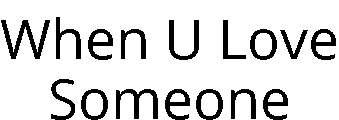

In [292]:
t.image

In [293]:
t.dimensions

(339, 120)

In [11]:
class CoverArt:
    def __init__(self, image=None, resolution=(1, 1), coordinates=(0,0)):
        self.resolution = resolution
        self.coordinates = coordinates
        self.image = image
        
    @property
    def image(self):
        return self._image
    
    @image.setter
    def image(self, image):
        im = Image.open(image)
        myImage = im.convert(mode='L', colors=2)
        myImage = myImage.resize((self.resolution))
        self._image = myImage
        
        
        
    

In [316]:
class Screen:
    def __init__(self, resolution=(600, 448), elements=[], epd=None):
        self.resolution = resolution
        self.elements = elements
        self.image = self.clearScreen()
        self.epd = epd
        
    @property
    def resolution(self):
        return self._resolution
    
    @resolution.setter
    def resolution(self, resolution):
        if self.coordcheck(resolution):
            self._resolution = resolution
    
    def clearScreen(self):
        '''sets base image for building screen to an empty background'''
        self.image = Image.new('L', self.resolution, 255)
        return self.image

    def concat(self, elements=None):
        if elements:
            elements = elements
        else:
            elements = self.elements
    
        for e in self.elements:
            logging.debug(f'pasting image at: {e.coordinates}')
            self.image.paste(e.image, (e.coordinates))
        return(self.image)
        
    def coordcheck(self, coordinates):
        for c in coordinates:
            if not isinstance(c, int):
                raise TypeError(f'coordinate must be type int: {c}')
                return False # redundant
            if c < 0:
                raise ValueError(f'coordinate must be positive: {c}')
                return False # redundant
        return True        
    
    def initEPD(self):
        if not self.epd:
            raise UnboundLocalError('no epd object has been assigned')
        try:
            self.epd.init()
        except Exception as e:
            logging.error(f'failed to init epd: {e}')
    
    def clearEPD(self):
        if not self.epd:
            raise UnboundLocalError('no epd object has been assigned')
        try:
            self.epd.Clear();
        except Exception as e:
            logging.error(f'failed to clear epd: {e}')
    
    def writeEPD(self, image=None, sleep=True):
        epd = self.epd
        if not self.epd:
            raise UnboundLocalError('no epd object has been assigned')
        try:
#             epd.display(epd.getbuffer(self.image), epd.getbuffer(Image.new('1', (epd.height, epd.width), 255)))
            epd.display(epd.getbuffer(self.image))
            if sleep:
                epd.sleep()
        except Exception as e:
            logging.error(f'failed to write to epd: {e}')
        
        

In [317]:
# the sections MUST be ordered logically so relative calculations can be made
# if section 'artist' depends on section 'title' for relative positioning, 
# 'artist' MUST be listed AFTER 'title'

twoColumn = {
    'coverart': { # coverart image
                'image': True, # has an image that may need to be resized
                'max_lines': None, # number of lines of text associated with this section
                'padding': 10, # amount of padding at edge
                'width': 1/3, # fraction of total width of display
                'height': 1, # fraction of total height
                'coordinates': (0, 0), # X, Y for top left position of section
                'hcenter': True, # horizontal center-align the contents
                'vcenter': True, # vertically center-align the contents
                'relative': False, # False if position is absolute
                'font': None,
                'fontsize': None # font size to use for text
    },
    'title': { # track title
                'image': None, # none if no image is needed
                'max_lines': 3, # number of lines of text associated with this section
                'padding': 10,  # padding at edge
                'width': 2/3, # fraction of total width of display
                'height': 3/5, # fraction of total height of display
                'coordinates': (None, 0), # X, Y for top left position of section
                                          # None indicates that the position is not known and will be calculated 
                                          # relative to another section
                                          # integer indicates an absolute position to use
                'hcenter': False, # horizontal center-align the contents
                'vcenter': True, # vertically center-align the contents
                'relative': ['coverart', 'title'], # [X Section coordinates+dimension, Y section coordinates+dimension]
                'font': None,
                'fontsize': None # font size to use for text

    },
    'artist': { # track artist
                'image': None,
                'max_lines': 2,
                'padding': 10,
                'width': 2/3,
                'height': 1/5,
                'coordinates': (None, None),
                'hcenter': False,
                'vcenter': True,
                'relative': ['coverart', 'title'],
                'font': None,
                'fontsize': None
    },
    'album': { #album name
                'image': None,
                'max_lines': 2,
                'padding': 10,
                'width': 2/3,
                'height': 1/5,
                'coordinates': (None, None),
                'hcenter': False,
                'vcenter': True,
                'relative': ['coverart', 'artist'],
                'font': None,
                'fontsize': None
        
    }
}

In [323]:
class Layout:
    def __init__(self, resolution=(600, 448), layout=None, font=constants.FONT):
        self.resolution = resolution
        self.font = str(Path(font).absolute())
        self.layout = copy.deepcopy(layout)
        self.images = None
    
    def _check_keys(self, dictionary={}, values={}):
        logging.debug('checking key/values')
        for k, v in values.items():
            try:
                dictionary[k]
            except KeyError as e:
                logging.debug(f'missing key: {k}; adding and setting to {v}')
                dictionary[k] = v
        return dictionary
    
    def _scalefont(self, font=constants.FONT, lines=1, text="W", resolution=(100, 100)):
        # start at fontsize 1 
        fontsize = 1
        y_fraction = .7
        target = resolution[1]/lines*y_fraction

        font = ImageFont.truetype(str(Path(constants.FONT).absolute()), fontsize)

        fontdim = font.getsize(text)

        # work up until font covers img_fraction of the resolution return one smaller than this as the fontsize
        while fontdim[1] < target:
            fontdim = font.getsize(text)
            fontsize +=1
            font = ImageFont.truetype(str(Path(constants.FONT).absolute()), fontsize)
#         fontsize -= 1
        logging.debug(f'target Y fontsize: {target}, fontsize: {fontsize}, fontdim: {fontdim}')
        
        return(fontsize)    
    
    @property
    def layout(self):
        return self._layout
    
    @layout.setter
    def layout(self, layout):
        logging.debug('calculating layout')
        if not layout:
            self._layout = None
        
        l = layout
        resolution = self.resolution
        # required values that will be used in calculating the layout
        values = {'image': None, 'max_lines': 1, 'padding': 0, 'width': 1, 'height': 1, 
                  'coordinates': None, 'hcenter': False, 'vcenter': False, 'relative': False, 
                  'font': self.font, 'fontsize': None, 'dimensions': None}
        for section in l:
            logging.debug(f'***{section}***')
            this_section = self._check_keys(l[section], values)
                    
            dimensions = (round(resolution[0]*this_section['width']), 
                          round(resolution[1]*this_section['height']))
            
            this_section['dimensions'] = dimensions
            logging.debug(f'dimensions: {dimensions}')
            
            # set the thumbnail_size to resize the image
            if this_section['image']:
                maxsize = min(this_section['dimensions'])-this_section['padding']*2
                this_section['thumbnail_size'] = (maxsize, maxsize)
            
            # calculate the relative position if needed
            # if either of the coordinates are set as "None" - attempt to calculate the position
            if this_section['coordinates'][0] is None or this_section['coordinates'][1] is None:
                logging.debug(f'has calculated position')
                # store coordinates
                pos = []
                # check each value in relative section
                for idx, r in enumerate(this_section['relative']):
                    if r == section:
                        # use the value from this_section
                        pos.append(this_section['coordinates'][idx])
                    else:
                        # use the value from another section
                        pos.append(l[r]['dimensions'][idx] + l[r]['coordinates'][idx])
                
                # save the values as a tuple
                this_section['coordinates']=(pos[0], pos[1])
            else:
                logging.debug('has explict position')
            logging.debug(f'coordinates={this_section["coordinates"]}')
            
            # calculate fontsize
            if this_section['max_lines']:
                if not this_section['font']:
                    this_section['font'] = self.font

                if not this_section['fontsize']:
                    this_section['fontsize'] = self._scalefont(font=this_section['font'], 
                                                               resolution=this_section['dimensions'],
                                                               lines=this_section['max_lines'])    

            l[section] = this_section
        self._layout = l
        
    def set_images(self, layout=None):
        if not layout:
            return {}
        
        blocks = {}
        for sec in layout:
            section = layout[sec]
            if section['max_lines']:
                logging.debug(f'***{sec}***)')
                logging.debug('set text block')
                blocks[sec] = TextBlock(resolution=section['dimensions'], text='.', font=section['font'], 
                                       size=section['fontsize'], max_lines=section['max_lines'],
                                       hcenter=section['hcenter'], vcenter=section['vcenter'],
                                       coordinates=section['coordinates'])
        self.blocks = blocks
                

In [324]:
L = Layout(resolution=(600, 448), layout=twoColumn)

DEBUG:root:calculating layout
DEBUG:root:***coverart***
DEBUG:root:checking key/values
DEBUG:root:missing key: dimensions; adding and setting to None
DEBUG:root:dimensions: (200, 448)
DEBUG:root:has explict position
DEBUG:root:coordinates=(0, 0)
DEBUG:root:***title***
DEBUG:root:checking key/values
DEBUG:root:missing key: dimensions; adding and setting to None
DEBUG:root:dimensions: (400, 269)
DEBUG:root:has calculated position
DEBUG:root:coordinates=(200, 0)
DEBUG:root:target Y fontsize: 62.766666666666666, fontsize: 60, fontdim: (55, 64)
DEBUG:root:***artist***
DEBUG:root:checking key/values
DEBUG:root:missing key: dimensions; adding and setting to None
DEBUG:root:dimensions: (400, 90)
DEBUG:root:has calculated position
DEBUG:root:coordinates=(200, 269)
DEBUG:root:target Y fontsize: 31.499999999999996, fontsize: 31, fontdim: (28, 33)
DEBUG:root:***album***
DEBUG:root:checking key/values
DEBUG:root:missing key: dimensions; adding and setting to None
DEBUG:root:dimensions: (400, 90)
DE

In [328]:
L.set_images(layout=L.layout)

DEBUG:root:***title***)
DEBUG:root:set text block
DEBUG:root:maximum characters/line: 12
DEBUG:root:coordinates: (200, 0)
DEBUG:root:coordinates: (200, 0)
DEBUG:root:coordinates: (200, 0)
DEBUG:root:total lines of text: 1
DEBUG:root:['.']
DEBUG:root:text image dimensions: (16, 66)
DEBUG:root:vertically centering coordinates
DEBUG:root:coordinates: (200, 102)
DEBUG:root:***artist***)
DEBUG:root:set text block
DEBUG:root:maximum characters/line: 23
DEBUG:root:coordinates: (200, 269)
DEBUG:root:coordinates: (200, 269)
DEBUG:root:coordinates: (200, 269)
DEBUG:root:total lines of text: 1
DEBUG:root:['.']
DEBUG:root:text image dimensions: (8, 34)
DEBUG:root:vertically centering coordinates
DEBUG:root:coordinates: (200, 297)
DEBUG:root:***album***)
DEBUG:root:set text block
DEBUG:root:maximum characters/line: 23
DEBUG:root:coordinates: (200, 359)
DEBUG:root:coordinates: (200, 359)
DEBUG:root:coordinates: (200, 359)
DEBUG:root:total lines of text: 1
DEBUG:root:['.']
DEBUG:root:text image dimen

In [331]:
L.blocks['title'].text = "Wasted"
# L.blocks['artist'].text = 'Dirty Projectors, David Bryne'
# L.blocks['album'].text = 'Knotty Pine / So Far Around the Bend'

DEBUG:root:total lines of text: 1
DEBUG:root:['Wasted']
DEBUG:root:text image dimensions: (210, 66)
DEBUG:root:vertically centering coordinates
DEBUG:root:coordinates: (200, 204)


In [302]:
ca = CoverArt('./cover.jpg', resolution=(180, 180), coordinates=(10, 114))

In [333]:
s = Screen(elements=[ca, L.blocks['title'], L.blocks['artist'], L.blocks['album']])

DEBUG:root:pasting image at: (10, 114)
DEBUG:root:pasting image at: (200, 204)
DEBUG:root:pasting image at: (200, 297)
DEBUG:root:pasting image at: (200, 387)


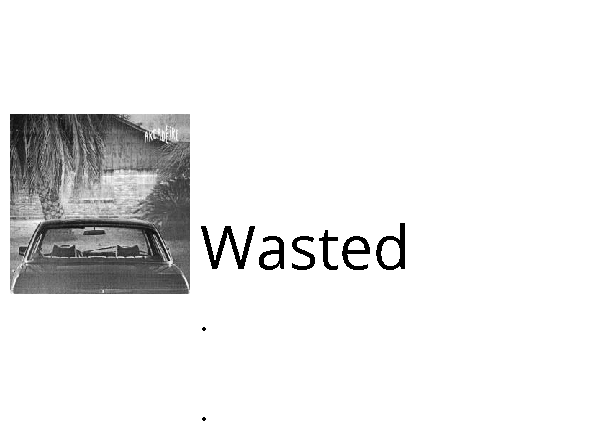

In [334]:
s.concat()

In [305]:
s.elements

In [315]:
for e in s.elements:
    print(e.coordinates)

(10, 114)
(200, 204)
(200, 301)
(200, 395)


In [278]:
e.coordinates

(200, 420)

In [447]:
s.epd = epd5in83.EPD()
s.initEPD()
# s.clearEPD()
s.writeEPD()

DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
DEBUG:root:imwidth = 600  imheight =  448 
DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
DEBUG:root:spi end
DEBUG:root:close 5V, Module enters 0 power consumption ...


In [213]:
L.calculate_layout()

DEBUG:root:calculating layout


In [416]:
l = None
l = dict(twoColumn)

resolution = (600, 448)
font = constants.FONT

for i in l:
    image = l[i]['image']
    textlines = l[i]['textlines']
    padding =  l[i]['padding'] if l[i]['padding'] else 0
    width = l[i]['width']
    height = l[i]['height']
    position = l[i]['position']
    center = l[i]['center']
    relative = l[i]['relative']
    dimensions = (round(resolution[0]*l[i]['width']), 
                  round(resolution[1]*l[i]['height']))
    fontsize = l[i]['fontsize']
    
    l[i]['dimensions'] = dimensions
    
        
    logger.debug(f'****{i}****')

    l[i]['dimensions'] = dimensions
    logger.debug(f'dimensions: {dimensions}')

    # check if there's coverart and resize it 
    if image and i=='coverart':
        logging.debug(f'has coverart')
        size = min(dimensions)-padding*2
        l[i]['imagedim'] = (size, size)
        if center:
            logging.debug('centered')
            position = (position[0]+padding, round(max(dimensions)/2-padding*2-size/2))
        
    if position:
        logging.debug(f'explicit position: {position}')
    else:
        logging.debug(f'calculating positions')
        pos = []
        for idx, k in enumerate(relative):
            if k == i:
                pos.append(relative[k])
            else:
                val = l[k]['position'][idx]+l[k]['dimensions'][idx]
                pos.append(val)        
        logging.debug(f'calculated position: {pos}')
        l[i]['position'] = pos
    
    if textlines:
        fontsize = round((dimensions[1]-padding*2-padding*textlines)/textlines)
        l[i]['fontsize'] = fontsize
        logging.debug(f'calculated fontsize: {fontsize}')
        

    
    




DEBUG:__main__:****coverart****
DEBUG:__main__:dimensions: (200, 448)
DEBUG:root:has coverart
DEBUG:root:centered
DEBUG:root:explicit position: (10, 114)
DEBUG:__main__:****title****
DEBUG:__main__:dimensions: (400, 269)
DEBUG:root:explicit position: [200, 1]
DEBUG:root:calculated fontsize: 73
DEBUG:__main__:****artist****
DEBUG:__main__:dimensions: (400, 90)
DEBUG:root:explicit position: [200, 270]
DEBUG:root:calculated fontsize: 25
DEBUG:__main__:****album****
DEBUG:__main__:dimensions: (400, 90)
DEBUG:root:explicit position: [200, 360]
DEBUG:root:calculated fontsize: 25


In [411]:
l

{'coverart': {'image': True,
  'textlines': None,
  'padding': 10,
  'width': 0.3333333333333333,
  'height': 1,
  'position': (0, 0),
  'center': True,
  'relative': False,
  'fontsize': None,
  'dimensions': (200, 448),
  'imagedim': (180, 180)},
 'title': {'image': None,
  'textlines': 3,
  'padding': 10,
  'width': 0.6666666666666666,
  'height': 0.6,
  'position': [200, 1],
  'center': False,
  'relative': {'coverart': 0, 'title': 1},
  'fontsize': 73,
  'dimensions': (400, 269)},
 'artist': {'image': None,
  'textlines': 2,
  'padding': 10,
  'width': 0.6666666666666666,
  'height': 0.2,
  'position': [200, 270],
  'center': False,
  'relative': {'coverart': 0, 'title': 1},
  'fontsize': 25,
  'dimensions': (400, 90)},
 'album': {'image': None,
  'textlines': 2,
  'padding': 10,
  'width': 0.6666666666666666,
  'height': 0.2,
  'position': [200, 360],
  'center': False,
  'relative': {'coverart': 0, 'artist': 1},
  'fontsize': 25,
  'dimensions': (400, 90)}}

In [398]:
l['coverart']

{'image': True,
 'textlines': None,
 'padding': 10,
 'width': 0.3333333333333333,
 'height': 1,
 'position': (0, 0),
 'center': True,
 'relative': False,
 'fontsize': None,
 'dimensions': (200, 448)}

In [393]:
t = TextBlock(resolution=(400, 269), text="Qabc Efghi Jklmno pqrstu 123 456 789 ABC DEF GHI", size=55, max_lines=3,
              coordinates=(200, 1), center=False)

DEBUG:root:maximum characters/line: 13
DEBUG:root:total lines: 3
DEBUG:root:['Qabc Efghi', 'Jklmno pqrstu', '123 456 [...]']
DEBUG:root:text dimension: (364, 212)


In [394]:
t.text = 'Yoshimi Battles the Pink Robots'

DEBUG:root:total lines: 3
DEBUG:root:['Yoshimi', 'Battles the', 'Pink Robots']
DEBUG:root:text dimension: (303, 180)


In [395]:
t.dimensions

(303, 180)

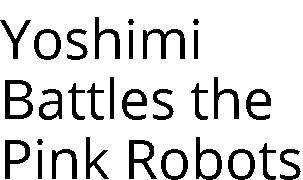

In [396]:
t.image

In [59]:
t.dimensions

(336, 197)

In [92]:
artistY = e.height-t.dimensions[1]
artistX = e.width-artistY
artistX, artistY

(269, 331)

In [63]:
a = TextBlock(text="abc def ghi jkl mno pqr stu vwx 123 456 789 ABC DEF GHI", resolution=(400, 90), size=26, coordinates=(200, 270), max_lines=2, center=False)

DEBUG:root:maximum characters/line: 27
DEBUG:root:total lines: 2
DEBUG:root:['abc def ghi jkl mno pqr stu', 'vwx 123 456 789 ABC DEF GHI']
DEBUG:root:text dimension: (364, 62)


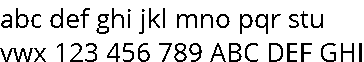

In [70]:
a.image

In [71]:
a.coordinates

(200, 270)

In [244]:
ca = CoverArt('./cover.jpg', resolution=(180, 180), coordinates=(10, 114))

In [251]:
cover = Image.open('./cover.jpg')
dim = min(cover.size)

248

In [249]:
cover.thumbnail((180, 180))

TypeError: 'int' object is not subscriptable

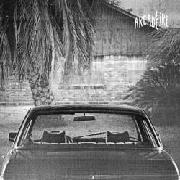

In [413]:
ca.image

In [350]:
e = epd5in83.EPD()

In [68]:
e.width, e.height

(600, 448)

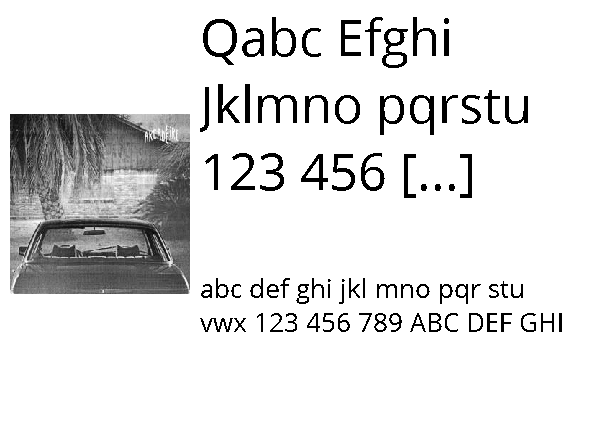

In [69]:
s = Screen(elements=[t, ca, a])
s.concat()

In [351]:
s.epd = epd5in83.EPD()
s.initEPD()
# s.clearEPD()
s.writeEPD()

DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
DEBUG:root:imwidth = 600  imheight =  448 
DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
DEBUG:root:spi end
DEBUG:root:close 5V, Module enters 0 power consumption ...


In [352]:
s.initEPD()
s.clearEPD()

DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
